In [1]:
!pip install -qU transformers colpali-engine datasets qdrant-client

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 327.7/327.7 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 88.9 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not

In [39]:
import os
from typing import List, Tuple, Dict
import torch
from datasets import Dataset, load_dataset
from torch.utils.data import DataLoader
from tqdm import tqdm
import uuid
import matplotlib.pyplot as plt

from qdrant_client import QdrantClient
from qdrant_client.http import models
from qdrant_client.http.models import PointStruct

from colpali_engine.models import ColQwen2, ColQwen2Processor

from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()

os.environ["HF_HUB_ENABLE_HF_TRANSFER"] = "1" # for faster downloads

### Loading Data

I have already converted the pdfs for Computer Science, Physics and Chemistry textbooks into HuggingFace using [PDF to Page Images Dataset Space](https://huggingface.co/spaces/Dataset-Tools/pdf-to-page-images-dataset) on HuggingFace to convert each PDF into it's own seperate dataset of images. This simplifies a huge part of the pre-processing pipeline because previously we had to convert each pdf to images using pdf2image package locally before embedding and indexing the textbooks.

In [3]:
comp_sci = load_dataset("zohaibterminator/9th-grade-comp-sci", split="train")
phys = load_dataset("zohaibterminator/9th-grade-phys", split="train")
chem = load_dataset("zohaibterminator/9th-grade-chem", split="train")

README.md:   0%|          | 0.00/1.11k [00:00<?, ?B/s]

Resolving data files:   0%|          | 0/44 [00:00<?, ?it/s]

computer_science.pdf_page_14.jpg:   0%|          | 0.00/101k [00:00<?, ?B/s]

computer_science.pdf_page_13.jpg:   0%|          | 0.00/101k [00:00<?, ?B/s]

computer_science.pdf_page_18.jpg:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

computer_science.pdf_page_20.jpg:   0%|          | 0.00/86.8k [00:00<?, ?B/s]

computer_science.pdf_page_23.jpg:   0%|          | 0.00/95.4k [00:00<?, ?B/s]

computer_science.pdf_page_16.jpg:   0%|          | 0.00/82.6k [00:00<?, ?B/s]

computer_science.pdf_page_17.jpg:   0%|          | 0.00/95.7k [00:00<?, ?B/s]

computer_science.pdf_page_1.jpg:   0%|          | 0.00/91.0k [00:00<?, ?B/s]

computer_science.pdf_page_11.jpg:   0%|          | 0.00/115k [00:00<?, ?B/s]

computer_science.pdf_page_19.jpg:   0%|          | 0.00/93.9k [00:00<?, ?B/s]

computer_science.pdf_page_24.jpg:   0%|          | 0.00/94.5k [00:00<?, ?B/s]

computer_science.pdf_page_26.jpg:   0%|          | 0.00/68.3k [00:00<?, ?B/s]

computer_science.pdf_page_27.jpg:   0%|          | 0.00/72.2k [00:00<?, ?B/s]

computer_science.pdf_page_25.jpg:   0%|          | 0.00/68.7k [00:00<?, ?B/s]

computer_science.pdf_page_15.jpg:   0%|          | 0.00/94.2k [00:00<?, ?B/s]

computer_science.pdf_page_10.jpg:   0%|          | 0.00/106k [00:00<?, ?B/s]

computer_science.pdf_page_21.jpg:   0%|          | 0.00/100k [00:00<?, ?B/s]

computer_science.pdf_page_29.jpg:   0%|          | 0.00/98.2k [00:00<?, ?B/s]

computer_science.pdf_page_12.jpg:   0%|          | 0.00/90.9k [00:00<?, ?B/s]

computer_science.pdf_page_22.jpg:   0%|          | 0.00/99.5k [00:00<?, ?B/s]

computer_science.pdf_page_30.jpg:   0%|          | 0.00/82.8k [00:00<?, ?B/s]

computer_science.pdf_page_31.jpg:   0%|          | 0.00/80.5k [00:00<?, ?B/s]

computer_science.pdf_page_32.jpg:   0%|          | 0.00/74.2k [00:00<?, ?B/s]

computer_science.pdf_page_33.jpg:   0%|          | 0.00/89.0k [00:00<?, ?B/s]

computer_science.pdf_page_3.jpg:   0%|          | 0.00/107k [00:00<?, ?B/s]

computer_science.pdf_page_28.jpg:   0%|          | 0.00/44.5k [00:00<?, ?B/s]

computer_science.pdf_page_2.jpg:   0%|          | 0.00/95.5k [00:00<?, ?B/s]

computer_science.pdf_page_34.jpg:   0%|          | 0.00/69.2k [00:00<?, ?B/s]

computer_science.pdf_page_36.jpg:   0%|          | 0.00/86.6k [00:00<?, ?B/s]

computer_science.pdf_page_37.jpg:   0%|          | 0.00/106k [00:00<?, ?B/s]

computer_science.pdf_page_35.jpg:   0%|          | 0.00/83.1k [00:00<?, ?B/s]

computer_science.pdf_page_39.jpg:   0%|          | 0.00/86.4k [00:00<?, ?B/s]

computer_science.pdf_page_40.jpg:   0%|          | 0.00/95.0k [00:00<?, ?B/s]

computer_science.pdf_page_4.jpg:   0%|          | 0.00/102k [00:00<?, ?B/s]

computer_science.pdf_page_41.jpg:   0%|          | 0.00/99.9k [00:00<?, ?B/s]

computer_science.pdf_page_43.jpg:   0%|          | 0.00/85.3k [00:00<?, ?B/s]

computer_science.pdf_page_44.jpg:   0%|          | 0.00/78.5k [00:00<?, ?B/s]

computer_science.pdf_page_6.jpg:   0%|          | 0.00/80.1k [00:00<?, ?B/s]

computer_science.pdf_page_38.jpg:   0%|          | 0.00/82.0k [00:00<?, ?B/s]

computer_science.pdf_page_7.jpg:   0%|          | 0.00/88.9k [00:00<?, ?B/s]

computer_science.pdf_page_8.jpg:   0%|          | 0.00/96.6k [00:00<?, ?B/s]

computer_science.pdf_page_5.jpg:   0%|          | 0.00/101k [00:00<?, ?B/s]

computer_science.pdf_page_9.jpg:   0%|          | 0.00/104k [00:00<?, ?B/s]

computer_science.pdf_page_42.jpg:   0%|          | 0.00/74.7k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/44 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/1.10k [00:00<?, ?B/s]

Resolving data files:   0%|          | 0/56 [00:00<?, ?it/s]

physics.pdf_page_13.jpg:   0%|          | 0.00/72.0k [00:00<?, ?B/s]

physics.pdf_page_17.jpg:   0%|          | 0.00/80.5k [00:00<?, ?B/s]

physics.pdf_page_18.jpg:   0%|          | 0.00/82.6k [00:00<?, ?B/s]

physics.pdf_page_14.jpg:   0%|          | 0.00/79.6k [00:00<?, ?B/s]

physics.pdf_page_19.jpg:   0%|          | 0.00/77.1k [00:00<?, ?B/s]

physics.pdf_page_2.jpg:   0%|          | 0.00/86.4k [00:00<?, ?B/s]

physics.pdf_page_1.jpg:   0%|          | 0.00/95.5k [00:00<?, ?B/s]

physics.pdf_page_21.jpg:   0%|          | 0.00/70.1k [00:00<?, ?B/s]

physics.pdf_page_10.jpg:   0%|          | 0.00/75.4k [00:00<?, ?B/s]

physics.pdf_page_16.jpg:   0%|          | 0.00/82.3k [00:00<?, ?B/s]

physics.pdf_page_15.jpg:   0%|          | 0.00/61.6k [00:00<?, ?B/s]

physics.pdf_page_12.jpg:   0%|          | 0.00/88.2k [00:00<?, ?B/s]

physics.pdf_page_23.jpg:   0%|          | 0.00/37.4k [00:00<?, ?B/s]

physics.pdf_page_11.jpg:   0%|          | 0.00/78.8k [00:00<?, ?B/s]

physics.pdf_page_20.jpg:   0%|          | 0.00/73.0k [00:00<?, ?B/s]

physics.pdf_page_25.jpg:   0%|          | 0.00/66.7k [00:00<?, ?B/s]

physics.pdf_page_22.jpg:   0%|          | 0.00/69.3k [00:00<?, ?B/s]

physics.pdf_page_24.jpg:   0%|          | 0.00/59.6k [00:00<?, ?B/s]

physics.pdf_page_26.jpg:   0%|          | 0.00/47.7k [00:00<?, ?B/s]

physics.pdf_page_29.jpg:   0%|          | 0.00/61.2k [00:00<?, ?B/s]

physics.pdf_page_3.jpg:   0%|          | 0.00/79.1k [00:00<?, ?B/s]

physics.pdf_page_27.jpg:   0%|          | 0.00/46.2k [00:00<?, ?B/s]

physics.pdf_page_30.jpg:   0%|          | 0.00/95.2k [00:00<?, ?B/s]

physics.pdf_page_28.jpg:   0%|          | 0.00/66.4k [00:00<?, ?B/s]

physics.pdf_page_32.jpg:   0%|          | 0.00/72.6k [00:00<?, ?B/s]

physics.pdf_page_31.jpg:   0%|          | 0.00/88.9k [00:00<?, ?B/s]

physics.pdf_page_33.jpg:   0%|          | 0.00/83.8k [00:00<?, ?B/s]

physics.pdf_page_34.jpg:   0%|          | 0.00/88.1k [00:00<?, ?B/s]

physics.pdf_page_35.jpg:   0%|          | 0.00/77.7k [00:00<?, ?B/s]

physics.pdf_page_36.jpg:   0%|          | 0.00/60.5k [00:00<?, ?B/s]

physics.pdf_page_40.jpg:   0%|          | 0.00/74.1k [00:00<?, ?B/s]

physics.pdf_page_37.jpg:   0%|          | 0.00/77.2k [00:00<?, ?B/s]

physics.pdf_page_47.jpg:   0%|          | 0.00/43.4k [00:00<?, ?B/s]

physics.pdf_page_38.jpg:   0%|          | 0.00/57.5k [00:00<?, ?B/s]

physics.pdf_page_43.jpg:   0%|          | 0.00/65.6k [00:00<?, ?B/s]

physics.pdf_page_41.jpg:   0%|          | 0.00/59.3k [00:00<?, ?B/s]

physics.pdf_page_45.jpg:   0%|          | 0.00/93.6k [00:00<?, ?B/s]

physics.pdf_page_44.jpg:   0%|          | 0.00/84.2k [00:00<?, ?B/s]

physics.pdf_page_46.jpg:   0%|          | 0.00/59.0k [00:00<?, ?B/s]

physics.pdf_page_39.jpg:   0%|          | 0.00/50.4k [00:00<?, ?B/s]

physics.pdf_page_42.jpg:   0%|          | 0.00/51.1k [00:00<?, ?B/s]

physics.pdf_page_4.jpg:   0%|          | 0.00/99.8k [00:00<?, ?B/s]

physics.pdf_page_48.jpg:   0%|          | 0.00/52.5k [00:00<?, ?B/s]

physics.pdf_page_49.jpg:   0%|          | 0.00/49.5k [00:00<?, ?B/s]

physics.pdf_page_50.jpg:   0%|          | 0.00/77.9k [00:00<?, ?B/s]

physics.pdf_page_5.jpg:   0%|          | 0.00/89.7k [00:00<?, ?B/s]

physics.pdf_page_51.jpg:   0%|          | 0.00/37.6k [00:00<?, ?B/s]

physics.pdf_page_53.jpg:   0%|          | 0.00/31.8k [00:00<?, ?B/s]

physics.pdf_page_54.jpg:   0%|          | 0.00/36.0k [00:00<?, ?B/s]

physics.pdf_page_7.jpg:   0%|          | 0.00/74.7k [00:00<?, ?B/s]

physics.pdf_page_8.jpg:   0%|          | 0.00/67.2k [00:00<?, ?B/s]

physics.pdf_page_56.jpg:   0%|          | 0.00/54.0k [00:00<?, ?B/s]

physics.pdf_page_52.jpg:   0%|          | 0.00/67.7k [00:00<?, ?B/s]

physics.pdf_page_6.jpg:   0%|          | 0.00/93.9k [00:00<?, ?B/s]

physics.pdf_page_55.jpg:   0%|          | 0.00/56.1k [00:00<?, ?B/s]

physics.pdf_page_9.jpg:   0%|          | 0.00/58.2k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/56 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/1.10k [00:00<?, ?B/s]

Resolving data files:   0%|          | 0/53 [00:00<?, ?it/s]

chemistry.pdf_page_14.jpg:   0%|          | 0.00/73.1k [00:00<?, ?B/s]

chemistry.pdf_page_10.jpg:   0%|          | 0.00/67.3k [00:00<?, ?B/s]

chemistry.pdf_page_20.jpg:   0%|          | 0.00/82.3k [00:00<?, ?B/s]

chemistry.pdf_page_16.jpg:   0%|          | 0.00/58.2k [00:00<?, ?B/s]

chemistry.pdf_page_19.jpg:   0%|          | 0.00/84.5k [00:00<?, ?B/s]

chemistry.pdf_page_17.jpg:   0%|          | 0.00/65.1k [00:00<?, ?B/s]

chemistry.pdf_page_12.jpg:   0%|          | 0.00/70.8k [00:00<?, ?B/s]

chemistry.pdf_page_1.jpg:   0%|          | 0.00/88.6k [00:00<?, ?B/s]

chemistry.pdf_page_23.jpg:   0%|          | 0.00/60.0k [00:00<?, ?B/s]

chemistry.pdf_page_15.jpg:   0%|          | 0.00/76.3k [00:00<?, ?B/s]

chemistry.pdf_page_21.jpg:   0%|          | 0.00/77.7k [00:00<?, ?B/s]

chemistry.pdf_page_22.jpg:   0%|          | 0.00/72.7k [00:00<?, ?B/s]

chemistry.pdf_page_13.jpg:   0%|          | 0.00/81.7k [00:00<?, ?B/s]

chemistry.pdf_page_18.jpg:   0%|          | 0.00/93.1k [00:00<?, ?B/s]

chemistry.pdf_page_2.jpg:   0%|          | 0.00/68.7k [00:00<?, ?B/s]

chemistry.pdf_page_11.jpg:   0%|          | 0.00/64.7k [00:00<?, ?B/s]

chemistry.pdf_page_24.jpg:   0%|          | 0.00/55.7k [00:00<?, ?B/s]

chemistry.pdf_page_29.jpg:   0%|          | 0.00/57.6k [00:00<?, ?B/s]

chemistry.pdf_page_25.jpg:   0%|          | 0.00/63.2k [00:00<?, ?B/s]

chemistry.pdf_page_27.jpg:   0%|          | 0.00/87.4k [00:00<?, ?B/s]

chemistry.pdf_page_28.jpg:   0%|          | 0.00/90.7k [00:00<?, ?B/s]

chemistry.pdf_page_33.jpg:   0%|          | 0.00/88.7k [00:00<?, ?B/s]

chemistry.pdf_page_34.jpg:   0%|          | 0.00/77.5k [00:00<?, ?B/s]

chemistry.pdf_page_36.jpg:   0%|          | 0.00/81.8k [00:00<?, ?B/s]

chemistry.pdf_page_3.jpg:   0%|          | 0.00/63.0k [00:00<?, ?B/s]

chemistry.pdf_page_35.jpg:   0%|          | 0.00/79.8k [00:00<?, ?B/s]

chemistry.pdf_page_37.jpg:   0%|          | 0.00/85.4k [00:00<?, ?B/s]

chemistry.pdf_page_26.jpg:   0%|          | 0.00/70.1k [00:00<?, ?B/s]

chemistry.pdf_page_30.jpg:   0%|          | 0.00/63.0k [00:00<?, ?B/s]

chemistry.pdf_page_31.jpg:   0%|          | 0.00/36.2k [00:00<?, ?B/s]

chemistry.pdf_page_32.jpg:   0%|          | 0.00/62.4k [00:00<?, ?B/s]

chemistry.pdf_page_38.jpg:   0%|          | 0.00/68.8k [00:00<?, ?B/s]

chemistry.pdf_page_39.jpg:   0%|          | 0.00/72.3k [00:00<?, ?B/s]

chemistry.pdf_page_43.jpg:   0%|          | 0.00/85.4k [00:00<?, ?B/s]

chemistry.pdf_page_4.jpg:   0%|          | 0.00/93.4k [00:00<?, ?B/s]

chemistry.pdf_page_46.jpg:   0%|          | 0.00/76.8k [00:00<?, ?B/s]

chemistry.pdf_page_45.jpg:   0%|          | 0.00/87.9k [00:00<?, ?B/s]

chemistry.pdf_page_40.jpg:   0%|          | 0.00/84.6k [00:00<?, ?B/s]

chemistry.pdf_page_44.jpg:   0%|          | 0.00/72.9k [00:00<?, ?B/s]

chemistry.pdf_page_42.jpg:   0%|          | 0.00/75.7k [00:00<?, ?B/s]

chemistry.pdf_page_41.jpg:   0%|          | 0.00/66.0k [00:00<?, ?B/s]

chemistry.pdf_page_47.jpg:   0%|          | 0.00/69.3k [00:00<?, ?B/s]

chemistry.pdf_page_5.jpg:   0%|          | 0.00/76.2k [00:00<?, ?B/s]

chemistry.pdf_page_52.jpg:   0%|          | 0.00/60.0k [00:00<?, ?B/s]

chemistry.pdf_page_48.jpg:   0%|          | 0.00/70.9k [00:00<?, ?B/s]

chemistry.pdf_page_50.jpg:   0%|          | 0.00/70.5k [00:00<?, ?B/s]

chemistry.pdf_page_49.jpg:   0%|          | 0.00/60.4k [00:00<?, ?B/s]

chemistry.pdf_page_51.jpg:   0%|          | 0.00/66.4k [00:00<?, ?B/s]

chemistry.pdf_page_9.jpg:   0%|          | 0.00/91.4k [00:00<?, ?B/s]

chemistry.pdf_page_7.jpg:   0%|          | 0.00/73.0k [00:00<?, ?B/s]

chemistry.pdf_page_6.jpg:   0%|          | 0.00/100k [00:00<?, ?B/s]

chemistry.pdf_page_8.jpg:   0%|          | 0.00/73.9k [00:00<?, ?B/s]

chemistry.pdf_page_53.jpg:   0%|          | 0.00/66.8k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/53 [00:00<?, ? examples/s]

### Defining Embedding Model

I will be using the standard ColPali model vidore/colqwen2-v0.1 which is a Visual Retriever based on Qwen's Qwen2 Vision Language model, specifically the 2B variant. We can use larger and newer visual retrievers as well. For more information on other models, you can refer to the [ViDoRE Benchmark Leaderboard](https://huggingface.co/spaces/vidore/vidore-leaderboard) on HuggingFace.

In [4]:
model = ColQwen2.from_pretrained(
    "vidore/colqwen2-v0.1", # model name
     torch_dtype=torch.bfloat16, # load the model in 16-bit precision
     device_map="cuda:0", # load the model in GPU
)
processor = ColQwen2Processor.from_pretrained("vidore/colqwen2-v0.1") # load the model's vision encoder

adapter_config.json:   0%|          | 0.00/728 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/56.5k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.85G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/220 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/74.0M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/619 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/4.30k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/392 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

### Initializing Qdrant Collection

Qdrant is one of the few vector stores that support multi-vector embeddings, so I will be using it as my vector store for storage and retrieval. You can also use Vespa, which is another vector store that supports multi-vector embeddings. To define a collection in Qdrant, we need to know the size of the vectors, the similarity measure, and an additonal MultiVector config, that lets the Qdrant know we are storing Multi-vectors, as well as define or comparitor, which in our case is the ColBERT's MaxSim.

In [7]:
vector_params = models.VectorParams( # vector parameters
    size=128, # length of individual vectors (128 in our case), depends on the embedding model
    distance=models.Distance.COSINE, # similarity measure
    multivector_config=models.MultiVectorConfig( # multivector config for similarity comparison
        comparator=models.MultiVectorComparator.MAX_SIM # use ColBERT's MAXSIM similarity
    ),
)

We will also define a Quantizaton config for reducing the precision of the vectors from 16-bit to 8-bit. We do this because with ColBERT and ColPali the size of the vectors that need to be stored are larger, because they encode the images and text into multi-vectors, which requres more space. Qdrant by default stores vectors in 32-bit floating points, which means each value in the multi-vectors are stored in 32-bit floating point numbers. By reducing the precision, we are saving space by storing each value of the multi-vectors in 8-bit integers instead of 16-bit floating point numbers.

In [8]:
scalar_quant = models.ScalarQuantizationConfig(
    type=models.ScalarType.INT8, # quantize vectors to 8-bit integers
    quantile=0.99,
    always_ram=False, # don't store the payload in RAM
)

In [15]:
COLLECTION_NAME = "textbook-embeddings" # collection name for the vectors

# initialize Qdrant's client
client = QdrantClient(
    url=user_secrets.get_secret("QDRANT_URL"),
    api_key=user_secrets.get_secret("QDRANT_API_KEY")
)

# create collection with the vector and quantization params
if not (client.collection_exists(collection_name=COLLECTION_NAME)):
    client.create_collection(
        collection_name=COLLECTION_NAME,
        optimizers_config=models.OptimizersConfigDiff(
            indexing_threshold=100
        ),
        vectors_config=vector_params,
        quantization_config=models.ScalarQuantization(
            scalar=scalar_quant,
        )
    )

### Indexing

In [16]:
id_counter = 0 # for unique ids for vector points

def upsert_to_qdrant(points: PointStruct) -> bool:
    """
    Upsert the passed data points into the vector store.
    Args:
        points (PointStruct): Data point containing vectors and metadata.

    Returns:
        bool: True if the data was upserted. False otherwise.
    """
    try:
        client.upsert(
            collection_name=COLLECTION_NAME,
            points=points,
            wait=False,
        )
    except Exception as e:
        print(f"Error during upsert: {e}")
        return False
    return True


def index_docs(subject: str, dataset: Dataset) -> None:
    """
    Divide dataset into batches and generate embeddings for upsertion
    Args:
        subject (str): Textbook for which data is being upserted. Also included in metadata for vectors.
        dataset (Dataset): Textbook images in the form of HF dataset.
    """
    batch_size = 2 # change depending on GPU resources available
    global id_counter

    with tqdm(total=len(dataset), desc="Indexing Progress") as pbar:
        for i in range(0, len(dataset), batch_size):
            batch = dataset[i : i + batch_size]
            images = batch["image"]

            with torch.no_grad():
                batch_images = processor.process_images(images).to(
                    model.device
                )
                image_embeddings = model(**batch_images)

            points = []
            for j, embedding in enumerate(image_embeddings):
                # convert the embedding to a list of vectors
                multivector = embedding.cpu().float().numpy().tolist()
                points.append(
                    models.PointStruct(
                        id=id_counter,  # we will use a global id counter to keep track of ids
                        vector=multivector,
                        payload={
                            "subject": subject, # for pre-filtering to restrict similarity search to some specific vectors
                            "row": i + j # for accessing actual image later
                        },
                    )
                )
                id_counter += 1 # increment for uniqueness

            try:
                upsert_to_qdrant(points)
            except Exception as e:
                print(f"Error during upsert: {e}")
                break

            pbar.update(batch_size)

    print(f"{subject} textbook Indexing complete!")

In [17]:
index_docs("Computer Science", comp_sci)

Indexing Progress: 100%|██████████| 44/44 [01:34<00:00,  2.14s/it]

Computer Science textbook Indexing complete!


In [18]:
index_docs("Physics", phys)

Indexing Progress: 100%|██████████| 56/56 [02:01<00:00,  2.17s/it]

Physics textbook Indexing complete!


In [19]:
index_docs("Chemistry", chem)

Indexing Progress: 54it [02:39,  2.95s/it]                        

Chemistry textbook Indexing complete!


### Querying the Vector Store

In [22]:
def search_images_by_text(query_text, top_k=3):
    # process and encode the text query
    with torch.no_grad():
        batch_query = processor.process_queries([query_text]).to(
            model.device
        )
        query_embedding = model(**batch_query)

    # convert the query embedding to a list of vectors
    multivector_query = query_embedding[0].cpu().float().numpy().tolist()

    # search in qdrant
    search_result = client.query_points(
        collection_name=COLLECTION_NAME,
        query=multivector_query,
        limit=top_k,
    )

    return search_result


def return_images(query_text, top_k=5):
    results = search_images_by_text(query_text, top_k)
    row_ids = [r.payload["row"] for r in results.points]
    return dataset.select(row_ids)

In [45]:
query_text = "What is a CPU?"
results = search_images_by_text(query_text, 3)

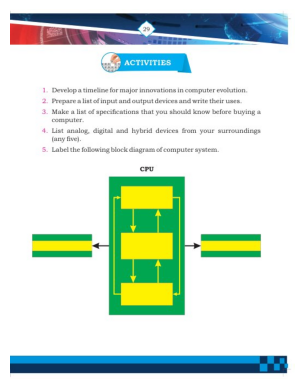

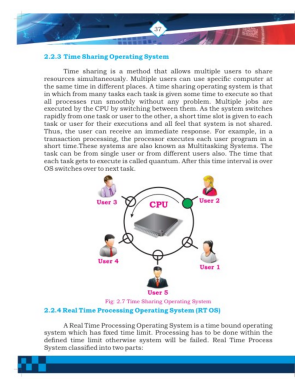

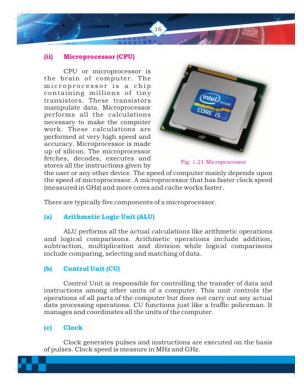

In [46]:
for point in results.points:
    if point.payload["subject"] == "Computer Science":
        plt.imshow(comp_sci["image"][(point.payload["row"])])
        plt.axis("off")
        plt.show()